# CPSC 599 NLP Project Experimentation

**Author:** 30093813


In [1]:
from util import change_extension, sliding_window
from collections import defaultdict, Counter
from urllib.parse import urlparse, urlunparse
import nltk
import spacy
from spacy.tokens import Token, DocBin
from spacy import displacy
import numpy as np
import en_core_web_sm
import re
import json
import os
import glob
import components
import pandas as pd


## Evaluating trained model


In [85]:
trained = spacy.load("./packages/en_pipeline-0.0.8/en_pipeline/en_pipeline-0.0.8/")
print(trained.pipe_names)
print(trained.component_names)
trained.analyze_pipes(pretty=True)
print()

['transformer', 'spancat']
['transformer', 'spancat']

============================= Pipeline Overview =============================

#   Component     Assigns          Requires   Scores       Retokenizes
-   -----------   --------------   --------   ----------   -----------
0   transformer   doc._.trf_data                           False      
                                                                      
1   spancat       doc.spans                   spans_sc_f   False      
                                              spans_sc_p              
                                              spans_sc_r              

✔ No problems found.



In [5]:
exs = ['One needs to fit the model to the data.', 'Refer to the glossary'
       , 'This was provided by Thomas Fan'
       , 'To provide a good fit the model needs to be trained.'
       , 'A pipeline can be used to improve the model by using cross validation.'
       , 'This is referred to as a warm start'
       , 'In classification the model is trained to predict a number of classes'
       , 'Classification algorithms usually also offer a way to quantify certainty of a prediction, either using decision_function or predict_proba'
       , 'All built-in estimators also have a set_params method, which sets data-independent parameters (overriding previous parameter values passed to __init__).'
       , 'y might be ignored in the case of unsupervised learning. However, to make it possible to use the estimator as part of a pipeline that can mix both supervised and unsupervised transformers, even unsupervised estimators need to accept a y=None keyword argument in the second position that is just ignored by the estimator.'
       , 'When fit is called, any previous call to fit should be ignored. In general, calling estimator.fit(X1) and then estimator.fit(X2) should be the same as only calling estimator.fit(X2). However, this may not be true in practice when fit depends on some random process, see random_state. Another exception to this rule is when the hyper-parameter warm_start is set to True for estimators that support it.'
       , 'Attributes that have been estimated from the data must always have a name ending with trailing underscore, for example the coefficients of some regression estimator would be stored in a coef_ attribute after fit has been called.'
       , 'Often, the subestimator has a name (as e.g. named steps in a Pipeline object), in which case the key should become <name>__C, <name>__class_weight, etc.'
       , 'Often, the subestimator has a name (as e.g. named steps in Pipeline objects), in which case the key should become <name>__C, <name>__class_weight, etc.'
       , 'For an estimator to be usable together with pipeline.Pipeline in any but the last step, it needs to provide a fit or fit_transform function. To be able to evaluate the pipeline on any data but the training set, it also needs to provide a transform function. There are no special requirements for the last step in a pipeline, except that it has a fit function. All fit and fit_transform functions must take arguments X, y, even if y is not used. Similarly, for score to be usable, the last step of the pipeline needs to have a score function that accepts an optional y.'
       , 'In a Pipeline object you can use GridSearchCV or RandomForestClassifier'
       , 'Whether you are proposing an estimator for inclusion in scikit-learn, developing a separate package compatible with scikit-learn, or implementing custom components for your own projects, this chapter details how to develop objects that safely interact with scikit-learn Pipelines and model selection tools.'
       , 'The base object, implements a fit method to learn from data'
       , 'Elements of the scikit-learn API are described more definitively in the Glossary of Common Terms and API Elements.']
# for doc in trained.pipe(exs):
#     show_spans(doc)
#     print()

In [86]:
doc1 = trained('The clothes need to fit you well.')
doc2 = trained('The estimator must support fit and transform. Note that using this feature requires that the DataFrame columns input at fit and transform have identical order.')
doc3 = trained('Note that using this feature requires that the DataFrame columns input at fit and transform have identical order.')
doc4 = trained('estimator. Note that using this feature requires that the DataFrame columns input at fit and transform have identical order.')
doc5 = trained('The clothes need to fit you well, you should use an estimator.')

displacy.render([doc1, doc2, doc3, doc4, doc5], style='span', options={'spans_key': 'sc'})

In [83]:
tests = ['Adrin Jalali',
         'jasdnvjlksnweoiurfhincvnjdasklfhu Adrin Jalali asjdfnljkdsnjlkwenfjwelfnjkldsaf',
         'Jalali',
         'Adrin',
         'Adrin F. Jalali did something',
         'Jalali Adrin',
         'A bunch of nonsense Adrin Jalali never seen before in the docs',
         'A bunch of nonsense Adrin Jalali has never seen before in the docs',
         'Adrin Jalali did something again in sklearn',
         'Adrin Jalali did something again in sklearn by Adrin Jalali',
         'Adrin Jalali and Adrin Jalali',
         'Adrin Jlali']

displacy.render(list(trained.pipe(tests)), style='span', options={'spans_key': 'sc'})

/home/calum/code/CPSC_599-NLP/project/.direnv/python-3.10.10/lib/python3.10/site-packages/spacy/displacy/__init__.py:242: UserWarning: [W117] No spans to visualize found in Doc object with spans_key: 'sc'. If this is surprising to you, make sure the Doc was processed using a model that supports span categorization, and check the `doc.spans[spans_key]` property manually if necessary.

Available keys: ['sc']
  warnings.warn(Warnings.W117.format(spans_key=spans_key, keys=keys))


In [45]:
db = DocBin().from_disk('data/split/test-15-33.spacy')
docs = list(db.get_docs(trained.vocab))

In [46]:
from spacy.training import Example
examples = [Example(predicted, reference) for predicted, reference in zip(trained.pipe(doc.text for doc in docs), docs)]

In [47]:
label_to_examples = defaultdict(list)
for example in examples:
    for s in example.reference.spans['sc']:
        label_to_examples[s.label_].append(example)

In [48]:
train_db = DocBin().from_disk('data/split/train-15-33.spacy')
train_docs = list(train_db.get_docs(trained.vocab))
label_to_train = defaultdict(list)
for doc in train_docs:
    for s in doc.spans['sc']:
        label_to_train[s.label_].append(doc)

In [49]:
test_counts = Counter(s.label_ for doc in docs for s in doc.spans['sc'])

In [50]:
from spacy.scorer import Scorer

attr_prefix = 'spans_'
scores = Scorer.score_spans(examples, attr=f'{attr_prefix}sc', getter=lambda doc, key: doc.spans.get(key[len(attr_prefix) :], []))
scores = pd.DataFrame(scores['spans_sc_per_type']).T.sort_values('f')
scores['support'] = scores.index.map(test_counts)
scores

,p,r,f,support
glossary.html#term-decision_function,0.500000,0.2,0.285714,5
https://twitter.com/ogrisel,0.500000,0.4,0.444444,5
modules/generated/sklearn.model_selection.gridsearchcv.html#sklearn.model_selection.gridsearchcv,0.500000,0.4,0.444444,5
generated/sklearn.pipeline.pipeline.html#sklearn.pipeline.pipeline,0.666667,0.4,0.500000,5
generated/sklearn.model_selection.gridsearchcv.html#sklearn.model_selection.gridsearchcv,0.428571,0.6,0.500000,5
...,...,...,...,...
modules/generated/sklearn.isotonic.isotonicregression.html#sklearn.isotonic.isotonicregression,1.000000,1.0,1.000000,5
http://www.ajoly.org,1.000000,1.0,1.000000,5
modules/generated/sklearn.decomposition.incrementalpca.html#sklearn.decomposition.incrementalpca,1.000000,1.0,1.000000,5
https://github.com/jeremiedbb,1.000000,1.0,1.000000,5


In [43]:
# scores.to_csv(os.path.join('output', 'model-best9', 'results.csv'))

In [53]:
def show_preds(label):
    for ex in label_to_train[label]:
        ex.user_data['title'] = f'Train doc {ex.user_data["file"]}'
        displacy.render([ex], style='span', options={'spans_key': 'sc'})
    for ex in label_to_examples[label]:
        ex.reference.user_data['title'] = f'Reference {ex.reference.user_data["file"]}'
        ex.predicted.user_data['title'] = f'Predicted {ex.reference.user_data["file"]}'
        displacy.render([ex.reference, ex.predicted], style='span', options={'spans_key': 'sc'})

In [84]:
show_preds('modules/generated/sklearn.manifold.tsne.html#sklearn.manifold.tsne')

## Exploring preprocessing


In [1]:
data_dir = 'data/html/processed/'
pattern = os.path.join(data_dir, '**', '*' + '.txt')
all_txt = glob.glob(pattern, recursive=True)
print(len(all_txt))

996

In [1]:
all_linkdata = []
all_links = []
for path in all_txt:
    with open(change_extension(path, '.linkdata.json'), 'r') as f:
        linkdata = json.load(f)
        all_linkdata.append(linkdata)
        for v in linkdata.values():
            all_links.append(v['link'])

all_links_set = set(all_links)

### Lowercasing


We should check if the linkdata would benefit from normalization. In
particular, it may be the case that the links are case insensitive, or
are relative paths, in which case two different strings could be
considered the same link.

There's a few links that are the same but with different
capitalization:


In [1]:
link_forms = defaultdict(list)
for link in all_links_set:
    link_forms[link.lower()].append(link)
for links in link_forms.values():
    if len(links) > 1:
        print(links)

#+begin_example
['https://github.com/GLevV', 'https://github.com/glevv']
['https://github.com/tomMoral', 'https://github.com/tommoral']
['#sklearn.covariance.OAS', '#sklearn.covariance.oas']
['https://github.com/Micky774', 'https://github.com/micky774']
['https://github.com/GuillemGSubies', 'https://github.com/guillemgsubies']
['https://github.com/NelleV', 'https://github.com/nellev']
['#sklearn.cluster.DBSCAN', '#sklearn.cluster.dbscan']
['#term-Y', '#term-y']
['#sklearn.decomposition.FastICA', '#sklearn.decomposition.fastica']
['https://github.com/NicolasHug', 'https://github.com/nicolashug']
['https://en.wikipedia.org/wiki/Mutual_information', 'https://en.wikipedia.org/wiki/Mutual_Information']
#+end_example

[Technically](https://www.w3.org/TR/WD-html40-970708/htmlweb.html) links are supposed to be case sensitive, but in this
dataset it appears we should treat the links as case insensitive. The
only questionable case is "term-y" vs "term-Y", however those both
lead to the same place ([here](https://scikit-learn.org/stable/glossary.html#term-y)). When making this a user-facing product,
it may be beneficial to have some settings around case sensitivity:
insensitive/sensitive by default, exceptions.


In [1]:
all_links_lower = [l.lower() for l in all_links]
all_links_lower_set = set(all_links_lower)

### Link normalization


Next we'll explore normalization of the urls.

Initial exploration indicated that the only part of the url that could
be allowed to vary while still considering links to be equivalent was
the scheme; in particular "http" vs "https". The host (`netloc`) cannot
vary due to cases like "github.com/username" and
"twitter.com/username". The query/params cannot vary due to cases of
websites that show different pages based on the query, for example
youtube or mybinder. The fragment cannot vary because it may be used
to point to different places within the same page. So we'll count the
cases where the scheme differs across examples:


In [1]:
link_paths = defaultdict(list)

for l in all_links_lower_set:
    parse = urlparse(l)
    p = parse.netloc + parse.path + parse.fragment + parse.query + parse.params
    if p != '':
        link_paths[p].append((l, parse))

change_scheme = {}
for links in link_paths.values():
    if len(links) > 1:
        print(links)
        has_scheme = lambda scheme, ls: filter(lambda l: l[1].scheme == scheme, ls)
        for httpsl, _ in has_scheme('https', links):
           for l, p in links:
               if p.scheme == 'http':
                   change_scheme[l] = httpsl

[('http://www.sciencedirect.com/science/article/pii/s016786550500303x', ParseResult(scheme='http', netloc='www.sciencedirect.com', path='/science/article/pii/s016786550500303x', params='', query='', fragment='')), ('https://www.sciencedirect.com/science/article/pii/s016786550500303x', ParseResult(scheme='https', netloc='www.sciencedirect.com', path='/science/article/pii/s016786550500303x', params='', query='', fragment=''))]
[('http://scikit-learn.org/stable/modules/sgd.html', ParseResult(scheme='http', netloc='scikit-learn.org', path='/stable/modules/sgd.html', params='', query='', fragment='')), ('https://scikit-learn.org/stable/modules/sgd.html', ParseResult(scheme='https', netloc='scikit-learn.org', path='/stable/modules/sgd.html', params='', query='', fragment=''))]
[('https://gael-varoquaux.info', ParseResult(scheme='https', netloc='gael-varoquaux.info', path='', params='', query='', fragment='')), ('http://gael-varoquaux.info', ParseResult(scheme='http', netloc='gael-varoquaux.i

Not that many, but still worth taking into account. For this case,
changing the scheme may actually break the link, so we'll only change
the scheme to "https" for cases where there is already an "https"
variation of the link. We'll also do a roundtrip of parsing the url,
which should normalize alternate forms of the same link (in particular
'' and '#').


In [1]:
print(urlunparse(urlparse('#')))

In [1]:
all_links_lower_norm = []
for l in all_links_lower:
    scheme_updated = change_scheme.get(l) or l
    all_links_lower_norm.append(urlunparse(urlparse(scheme_updated)))
print(len(change_scheme))
print(len(set(all_links_lower)))
all_links_lower_norm_set = set(all_links_lower_norm)
print(len(all_links_lower_norm_set))

6
16905
16899

### Relative links


Finally we look at normalizing relative paths:


In [1]:
def norm_relative_link(link):
    if link.startswith('./') or link.startswith('../'):
        return re.sub(r'^(\.?\./)+', '', link)
    return link

link_tails = defaultdict(list)

for l in all_links_lower_norm_set:
    norm = norm_relative_link(l)
    link_tails[norm].append(l)

multis = [(norm, links) for norm, links in link_tails.items() if len(links) > 1]

print('Number of links with the same tail but different strings:', len(multis))
for norm, links in multis[:5]:
    if len(links) > 1:
        print(norm, links)

Number of links with the same tail but different strings: 646
datasets/toy_dataset.html#iris-dataset ['../../datasets/toy_dataset.html#iris-dataset', '../datasets/toy_dataset.html#iris-dataset']
auto_examples/svm/plot_svm_anova.html#sphx-glr-auto-examples-svm-plot-svm-anova-py ['../../auto_examples/svm/plot_svm_anova.html#sphx-glr-auto-examples-svm-plot-svm-anova-py', '../auto_examples/svm/plot_svm_anova.html#sphx-glr-auto-examples-svm-plot-svm-anova-py']
modules/clustering.html#clustering-evaluation ['../modules/clustering.html#clustering-evaluation', '../../modules/clustering.html#clustering-evaluation']
modules/generated/sklearn.impute.iterativeimputer.html#sklearn.impute.iterativeimputer ['../modules/generated/sklearn.impute.iterativeimputer.html#sklearn.impute.iterativeimputer', '../../modules/generated/sklearn.impute.iterativeimputer.html#sklearn.impute.iterativeimputer']
modules/generated/sklearn.preprocessing.standardscaler.html#sklearn.preprocessing.standardscaler ['../modules

We see there are a lot of cases where two different strings refer to
the same location due to the relative link structure. Relative paths
are something the can be rebuilt automatically, so we'll normalize
these as well:


In [1]:
all_links_processed = [norm_relative_link(l) for l in all_links_lower_norm if l != '']
print(len(all_links_set))
print(len(set(all_links_processed)))

16916
16162

We see that we have reduced the total number of classes by about 800,
but this is likely still too many.


## Reducing class count

In [14]:
db = DocBin().from_disk('data/data.spacy')
docs = list(db.get_docs(trained.vocab))
print(len(docs))

11315


In [15]:
c = Counter()
for s in (s for doc in docs for s in doc.spans['sc']):
    c[s.label_] += 1
print('Total classes:\t', len(c))
print('Total classes with at least 2 examples:\t', len({k: v for k, v in c.items() if v >= 2}))

Total classes:	 9715
Total classes with at least 2 examples:	 1606


In [16]:
def count_ge_to(counts, n):
    return [k for k, v in counts.items() if v >= n]

We see that the majority of links have few examples, and a minority
are heavily used. Fortunately for this application, we can focus our
efforts on classifying the most heavily used links, as those are the
links which will most likely be needed again.

In [17]:
for n in range(50):
    links = count_ge_to(c, n)
    print(f'Number of classes with at least {n} example(s):', len(links), sep='\t')

Number of classes with at least 0 example(s):	9715
Number of classes with at least 1 example(s):	9715
Number of classes with at least 2 example(s):	1606
Number of classes with at least 3 example(s):	880
Number of classes with at least 4 example(s):	618
Number of classes with at least 5 example(s):	453
Number of classes with at least 6 example(s):	331
Number of classes with at least 7 example(s):	257
Number of classes with at least 8 example(s):	207
Number of classes with at least 9 example(s):	176
Number of classes with at least 10 example(s):	157
Number of classes with at least 11 example(s):	136
Number of classes with at least 12 example(s):	123
Number of classes with at least 13 example(s):	109
Number of classes with at least 14 example(s):	101
Number of classes with at least 15 example(s):	89
Number of classes with at least 16 example(s):	80
Number of classes with at least 17 example(s):	68
Number of classes with at least 18 example(s):	64
Number of classes with at least 19 example

We can visualize the relationship between the number of examples and
the number of classes:


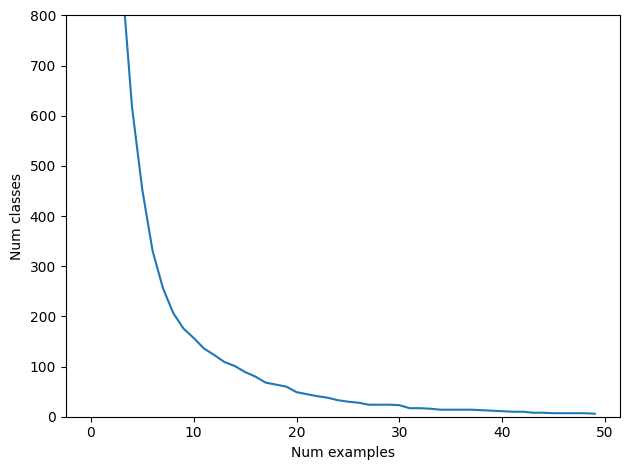

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x = range(50)
ax.plot(x, [len(count_ge_to(c, n)) for n in x])
ax.set_xlabel('Num examples')
ax.set_ylabel('Num classes')
plt.ylim([0, 800])
fig.tight_layout()
plt.savefig('images/numclasses.png')
plt.show()

## Train/test splitting


We can make preprocessed data splits using:

    python train_test_split.py data/ <min_examples> <test_size>

This script is a tool to split the data while trying to keep a good
amount of examples in the training and test sets, but it's not
perfect.

We'll explore which data set provides the best balance between number
of classes and number of examples in the test and train sets.


In [20]:
def show_data_summary(docs, desired_examples, show_classes):
    totals = Counter(s.label_ for doc in docs for s in doc.spans['sc'])
    counts = pd.DataFrame([{'count': count, 'link': link} for link, count in totals.items()])
    counts = counts.set_index('link')
    print('Total classes:\t', len(totals))
    print(f'Total classes with desired number of examples ({desired_examples}):\t',
          len({k: v for k, v in totals.items() if v >= desired_examples}))
    if show_classes:
        print('Classes:', sorted([(v, k) for k, v in totals.items()], reverse=True))
    return counts

In [29]:
def summarize_data_split(min_examples, test_size, show_classes=False):
    train_path = os.path.join('data', 'split', f'train-{min_examples}-{test_size*100:.0f}.spacy')
    test_path = os.path.join('data', 'split', f'test-{min_examples}-{test_size*100:.0f}.spacy')
    train_data = list(DocBin().from_disk(train_path).get_docs(trained.vocab))
    test_data = list(DocBin().from_disk(test_path).get_docs(trained.vocab))
    print('Min examples:', min_examples, '| Test size:', test_size, f'| Train/test counts: {len(train_data)}/{len(test_data)}')
    print('(train)')
    train_summary = show_data_summary(train_data, int(min_examples*(1-test_size)), show_classes)
    print('(test)')
    test_summary = show_data_summary(test_data, int(min_examples*test_size), show_classes)

    print('Training and testing classes are the same:', set(train_summary.index) == set(test_summary.index))
    print()
    train_summary = train_summary.rename(columns={'count': 'train_count'})
    train_summary['test_count'] = test_summary['count']
    return train_data, test_data, train_summary

In [30]:
for m in [5, 10, 15, 20, 25, 30]:
    summarize_data_split(m, 0.33)

Min examples: 5 | Test size: 0.33 | Train/test counts: 1113/398
(train)
Total classes:	 453
Total classes with desired number of examples (3):	 453
(test)
Total classes:	 453
Total classes with desired number of examples (1):	 453
Training and testing classes are the same: True

Min examples: 10 | Test size: 0.33 | Train/test counts: 933/417
(train)
Total classes:	 157
Total classes with desired number of examples (6):	 157
(test)
Total classes:	 157
Total classes with desired number of examples (3):	 157
Training and testing classes are the same: True

Min examples: 15 | Test size: 0.33 | Train/test counts: 786/406
(train)
Total classes:	 89
Total classes with desired number of examples (10):	 89
(test)
Total classes:	 89
Total classes with desired number of examples (4):	 89
Training and testing classes are the same: True

Min examples: 20 | Test size: 0.33 | Train/test counts: 584/274
(train)
Total classes:	 49
Total classes with desired number of examples (13):	 49
(test)
Total cla

In [31]:
for m in [5, 10, 15, 20, 25, 30]:
    summarize_data_split(m, 0.1)

Min examples: 5 | Test size: 0.1 | Train/test counts: 1505/374
(train)
Total classes:	 453
Total classes with desired number of examples (4):	 453
(test)
Total classes:	 387
Total classes with desired number of examples (0):	 387
Training and testing classes are the same: False

Min examples: 10 | Test size: 0.1 | Train/test counts: 1213/149
(train)
Total classes:	 157
Total classes with desired number of examples (9):	 157
(test)
Total classes:	 157
Total classes with desired number of examples (1):	 157
Training and testing classes are the same: True

Min examples: 15 | Test size: 0.1 | Train/test counts: 1030/86
(train)
Total classes:	 89
Total classes with desired number of examples (13):	 89
(test)
Total classes:	 89
Total classes with desired number of examples (1):	 89
Training and testing classes are the same: True

Min examples: 20 | Test size: 0.1 | Train/test counts: 806/93
(train)
Total classes:	 49
Total classes with desired number of examples (18):	 49
(test)
Total classe

In [32]:
for m in [5, 10, 15, 20, 25, 30]:
    summarize_data_split(m, 0.15)

Min examples: 5 | Test size: 0.15 | Train/test counts: 1138/427
(train)
Total classes:	 453
Total classes with desired number of examples (4):	 12
(test)
Total classes:	 452
Total classes with desired number of examples (0):	 452
Training and testing classes are the same: False

Min examples: 10 | Test size: 0.15 | Train/test counts: 1080/136
(train)
Total classes:	 157
Total classes with desired number of examples (8):	 157
(test)
Total classes:	 157
Total classes with desired number of examples (1):	 157
Training and testing classes are the same: True

Min examples: 15 | Test size: 0.15 | Train/test counts: 1038/160
(train)
Total classes:	 89
Total classes with desired number of examples (12):	 89
(test)
Total classes:	 89
Total classes with desired number of examples (2):	 89
Training and testing classes are the same: True

Min examples: 20 | Test size: 0.15 | Train/test counts: 766/139
(train)
Total classes:	 49
Total classes with desired number of examples (17):	 49
(test)
Total c

In [35]:
train_data, test_data, data_summary = summarize_data_split(15, 0.33)

Min examples: 15 | Test size: 0.33 | Train/test counts: 786/406
(train)
Total classes:	 89
Total classes with desired number of examples (10):	 89
(test)
Total classes:	 89
Total classes with desired number of examples (4):	 89
Training and testing classes are the same: True



In [36]:
data_summary.describe()

,train_count,test_count
count,89.0,89.0
mean,10.0,5.0
std,0.0,0.0
min,10.0,5.0
25%,10.0,5.0
50%,10.0,5.0
75%,10.0,5.0
max,10.0,5.0


In [227]:
def manual_balance(X):
    totals = Counter(s.label_ for doc in X for s in doc.spans['sc'])
    summary = pd.DataFrame([{
        'count': count,
        'link': link
    } for link, count in totals.items()])
    summary = summary.set_index('link')
    min_count = summary.min()['count']
    summary['count_r'] = summary['count']
    Xb = []
    for doc in X:
        spans = doc.spans['sc']
        if len(spans) == 0:
            continue
        counts = Counter(s.label_ for s in spans)
        count_r = summary['count_r'].loc[list(counts.keys())]
        df = pd.DataFrame([{
            'link': k,
            'count_r': c
        } for k, c in counts.items()]).set_index('link')
        count_r -= df['count_r']
        if all(count_r >= min_count):
            summary['count_r'].loc[count_r.index] = count_r
        else:
            Xb.append(doc)
    return Xb, summary
    
X_train, train_r_summary = manual_balance(train_data)
X_test, test_r_summary = manual_balance(test_data)
len(X_train), len(X_test)

(786, 406)

In [224]:
train_r_summary.describe()

,count,count_r
count,89.000000,89.0
mean,18.191011,10.0
std,14.185361,0.0
min,10.000000,10.0
25%,11.000000,10.0
50%,14.000000,10.0
75%,19.000000,10.0
max,117.000000,10.0


In [225]:
test_r_summary.describe()

,count,count_r
count,89.000000,89.0
mean,9.000000,5.0
std,6.969088,0.0
min,5.000000,5.0
25%,6.000000,5.0
50%,7.000000,5.0
75%,10.000000,5.0
max,57.000000,5.0


## Removing duplicates


In [1]:
test_db = DocBin().from_disk('data/iter6/test.spacy')
train_db = DocBin().from_disk('data/iter6/train.spacy')
test_docs = list(test_db.get_docs(trained.vocab))
train_docs = list(train_db.get_docs(trained.vocab))
print(len(test_docs), len(train_docs))

386 3860

In [1]:
def remove_duplicates(docs, seen):
    new_docs = []
    for i, doc in enumerate(docs):
        # print('Doc:', i)
        spans = doc.spans['sc']
        spans_set = set(spans)
        spans_used = set()
        no_duplicates = True
        for tokens in sliding_window(doc, 8):
            ts = (' '.join(t.text.strip() for t in tokens)).lower()
            all_spans_used = False
            for span in filter(lambda s: any(t in s for t in tokens), spans):
                if (ts, span.label) in seen:
                    # print('Duplicate found:', ts)
                    no_duplicates = False
                    all_spans_used = spans_used == spans_set
                else:
                    seen.add((ts, span.label))
                    spans_used.add(span)
            if all_spans_used:
                break
        if no_duplicates:
            new_docs.append(doc)
    return new_docs, seen

In [1]:
seen = set()
new_test_docs, seen = remove_duplicates(test_docs, seen)
print(len(test_docs), len(new_test_docs))

386 259

In [1]:
new_train_docs, seen = remove_duplicates(train_docs, seen)
print(len(train_docs), len(new_train_docs))

3860 1341

In [1]:
def show_docs_summary(docs, desired_examples, show_classes):
    totals = defaultdict(int)
    for link in (s.label_ for d in docs for s in d.spans['sc']):
        totals[link] += 1
    print('Total classes:\t', len(totals))
    print('Total classes with desired number of examples:\t', len({k: v for k, v in totals.items() if v >= desired_examples}))
    if show_classes:
        print('Classes:', sorted([(v, k) for k, v in totals.items()], reverse=True))
    return len(totals)

In [1]:
def summarize_docs_split(train_docs, test_docs, show_classes=False):
    print(f'Train/test counts: {len(train_docs)}/{len(test_docs)}')
    print('(train)')
    trainclasses = show_docs_summary(train_docs, 2, show_classes)
    print('(test)')
    testclasses = show_docs_summary(test_docs, 1, show_classes)
    print('Num classes with no test examples:', trainclasses - testclasses)
    print()

In [1]:
summarize_data_split(30, 0.05)
print()
summarize_docs_split(new_train_docs, new_test_docs)
summarize_docs_split(train_docs, test_docs)

#+begin_example
Min examples: 30 | Test size: 0.05 | Train/test counts: 947/49
(train)
Total classes:	 69
Total classes with desired number of examples:	 69
(test)
Total classes:	 69
Total classes with desired number of examples:	 59
Num classes with no test examples: 0


Train/test counts: 1341/259
(train)
Total classes:	 60
Total classes with desired number of examples:	 59
(test)
Total classes:	 63
Total classes with desired number of examples:	 63
Num classes with no test examples: -3

Train/test counts: 3860/386
(train)
Total classes:	 69
Total classes with desired number of examples:	 69
(test)
Total classes:	 63
Total classes with desired number of examples:	 63
Num classes with no test examples: 6
#+end_example

In [1]:
def make_db(docs, name):
    db = DocBin()
    for doc in docs:
        db.add(doc)
    db.to_disk(f'{name}.spacy')

In [1]:
make_db(new_train_docs, 'train-no-dups')
make_db(new_test_docs, 'test-no-dups')